# Section 2
You would have received a US_Arrest_Data.zip file with 8 datasets in .csv format and 3 data dictionaries in .docx format. You may or may not use all the datasets during this assessment.

In [1]:
## Imports
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

In [2]:
## DEFINE DATA PATH OF INTEREST
US_ARREST_DATA_DIR = os.path.join(os.getcwd(), "data", "US_Arrest_Data")

Dataset to consider:
- **US State related data**:
    *USArrest*: A data frame with 50 observations on 4 variables. It contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

    |Column|Type|Description|
    |---|---|---|
    |Murder|numeric|Murder arrests (per 100,000) in 1973|
    |Assault|numeric|Assault arrests (per 100,000) in 1973|
    |UrbanPop|numeric|Percent urban population in 1973|
    |Rape|numeric|Rape arrests (per 100,000) in 1973|
    
    <br/>
    
    For the following datasets, based on the dictionary provided which indicates all data are arranged according to alphabetical order of the state names, we just simply join the information rowwise by index.

    *USstatedivision*: Factor giving state divisions (New England, Middle Atlantic, South Atlantic, East South Central, West South Central, East North Central, West North Central, Mountain, and Pacific).
    
    *USstateregion*: Factor giving the region (Northeast, South, North Central, West) that each state belongs to.
    
    *USstatex77*: Matrix with 50 rows and 8 columns giving the following statistics in the respective columns as follows:
    <br/>
    <br/>
    
    |Column|Description|
    |---|---|
    |Population|Population estimate as of July 1, 1975|
    |Income|Per capita income (1974)|
    |Illiteracy|Illiteracy (1970, percent of population)|
    |Life Exp|Life expectancy in years (1969–71)|
    |Murder|Murder and non-negligent manslaughter rate per 100,000 population (1976)|
    |HS Grad|Percent high-school graduates (1970)|
    |Frost|Mean number of days with minimum temperature below freezing (1931–1960) in capital or large city|
    |Area|Land area in square miles|

    Based on information provided via page 24 of Chapter 6 the United States Census Bureau document accessable via: https://www2.census.gov/geo/pdfs/reference/GARM/Ch6GARM.pdf, and noting the data is based on 1970s, it is noted that reach US region can be further segmented into divisions as follows, which can be used as a countercheck when joining the above 3 dataset together:

    |Region|Division|
    |---|---|
    |Northeast|New England, Middle Atlantic|
    |North Central Region|East North Central, West North Central|
    |South|South Atlantic, East South Central, West South Central|
    |West|Mountain, Pacific|


Other state datasets not considered:
|Dataset|Description|Reason for not including|
|---|---|---|
|*USstateabb*|character vector of 2-letter abbreviations for the state names.|This is included in *USStatex77* dataset.|
|*USstatearea*|Numeric vector of state areas (in square miles).| Such data is included in *USStatex77* dataset and only some form of identifier is provided instead of actual state name.|
|*USstatecenter*|List with components named x and y giving the approximate geographic center of each state in negative longitude and latitude.Alaska and Hawaii are placed just off the West Coast.|Geographic coordinates of states is not an useful feature for categorisation since we cannot compare such data between states.|


In [3]:
# Required data files path and load data
US_STATE_DIVISION_PATH = os.path.join(US_ARREST_DATA_DIR, "USstatedivision.csv")
US_STATE_REGION_PATH = os.path.join(US_ARREST_DATA_DIR, "USstateregion.csv")
US_STATE_MATRIX_PATH = os.path.join(US_ARREST_DATA_DIR, "USstatex77.csv")
US_ARREST_DATA_PATH = os.path.join(US_ARREST_DATA_DIR, "USArrest.csv")

us_state_division_df = pd.read_csv(US_STATE_DIVISION_PATH,
                                   sep=",",
                                   header=0)
us_state_region_df = pd.read_csv(US_STATE_REGION_PATH,
                                 sep=",",
                                 header=0)
us_state_matrix_df = pd.read_csv(US_STATE_MATRIX_PATH,
                                 sep=",",
                                 header=0)

us_state_arrest_df = pd.read_csv(US_ARREST_DATA_PATH,
                                 sep=",",
                                 header=0)


Quick check on respective data entries type.

A quick check on actual data and summary of data indicates that there is no nulls. So we can simply work with the data without any imputation.

In [4]:
print(us_state_division_df.head())
us_state_division_df.info()

   Unnamed: 0                   x
0           1  East South Central
1           2             Pacific
2           3            Mountain
3           4  West South Central
4           5             Pacific
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50 non-null     int64 
 1   x           50 non-null     object
dtypes: int64(1), object(1)
memory usage: 928.0+ bytes


In [5]:
print(us_state_region_df.head())
us_state_region_df.info()

   Unnamed: 0      x
0           1  South
1           2   West
2           3   West
3           4  South
4           5   West
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50 non-null     int64 
 1   x           50 non-null     object
dtypes: int64(1), object(1)
memory usage: 928.0+ bytes


In [6]:
# Drop Unnamed column
us_state_division_df.drop(columns="Unnamed: 0", inplace=True)
us_state_region_df.drop(columns="Unnamed: 0", inplace=True)

# Rename columns of US State division/region to meaningful names
us_state_division_df.rename(columns={"x": "Division"}, inplace=True)
us_state_region_df.rename(columns={"x": "Region"}, inplace=True)

In [7]:
print(us_state_matrix_df.head())

# Rename the 'Unnamed: 0' and 'Murder' column to meaningful name
us_state_matrix_df.rename(columns={"Unnamed: 0": "State", "Murder": "Murder_Manslaughter_Rate_per100K"}, inplace=True)

us_state_matrix_df.info()

   Unnamed: 0  Population  Income  Illiteracy  Life Exp  Murder  HS Grad  \
0     Alabama        3615    3624         2.1     69.05    15.1     41.3   
1      Alaska         365    6315         1.5     69.31    11.3     66.7   
2     Arizona        2212    4530         1.8     70.55     7.8     58.1   
3    Arkansas        2110    3378         1.9     70.66    10.1     39.9   
4  California       21198    5114         1.1     71.71    10.3     62.6   

   Frost    Area  
0     20   50708  
1    152  566432  
2     15  113417  
3     65   51945  
4     20  156361  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State                             50 non-null     object 
 1   Population                        50 non-null     int64  
 2   Income                            50 non-null     int64  
 3   Illiter

In [8]:
print(us_state_arrest_df.head())

# Rename the 'Unnamed: 0' column to meaningful name
us_state_arrest_df.rename(columns={"Unnamed: 0": "State", "Murder": "Murder_Arrest_per100K", "Assault":"Assault_Arrest_per100K", "Rape": "Rape_Arrest_per100K"}, inplace=True)
us_state_arrest_df.info()

   Unnamed: 0  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   50 non-null     object 
 1   Murder_Arrest_per100K   50 non-null     float64
 2   Assault_Arrest_per100K  50 non-null     int64  
 3   UrbanPop                50 non-null     int64  
 4   Rape_Arrest_per100K     50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Since there are no nulls in the dataset with 50 entries, and by assumption that the data is ordered in alphabetical order for US states, we will join the 3 non-arrest related datasets rowwise, before merging with arrest related data (*us_state_arrest_df*) using the state column information as merging feature reference. 

In [9]:
list_of_dataframe_to_concat = [
    us_state_matrix_df,
    us_state_division_df,
    us_state_region_df,
]
us_data_concat_df = pd.concat(list_of_dataframe_to_concat, axis=1)
us_data_df = pd.merge(us_data_concat_df, us_state_arrest_df)
us_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State                             50 non-null     object 
 1   Population                        50 non-null     int64  
 2   Income                            50 non-null     int64  
 3   Illiteracy                        50 non-null     float64
 4   Life Exp                          50 non-null     float64
 5   Murder_Manslaughter_Rate_per100K  50 non-null     float64
 6   HS Grad                           50 non-null     float64
 7   Frost                             50 non-null     int64  
 8   Area                              50 non-null     int64  
 9   Division                          50 non-null     object 
 10  Region                            50 non-null     object 
 11  Murder_Arrest_per100K             50 non-null     float64
 12  Assault_Ar

Verify the data dictionary description on state-division state-region mapping based on information from external link . Comparing the concatenated division-region columns against the columns identified by 'check' prefixes representing the ground truth of mapping, it is noted that the data dictionary description on the state-division and state-region mapping holds true.

In [10]:
division_region_mapping_dict = {
    "New England": "Northeast",
    "Middle Atlantic": "Northeast",
    "East North Central": "North Central",
    "West North Central": "North Central",
    "South Atlantic": "South",
    "East South Central": "South",
    "West South Central": "South",
    "Mountain": "West",
    "Pacific": "West"
}

state_region_mapping_dict = {
    "Maine": "Northeast",
    "New Hampshire": "Northeast",
    "Vermont": "Northeast",
    "Massachusetts": "Northeast",
    "Rhode Island": "Northeast",
    "Connecticut": "Northeast",
    "New York": "Northeast",
    "New Jersey": "Northeast",
    "Pennsylvania": "Northeast",
    "Ohio": "North Central",
    "Indiana": "North Central",
    "Illinois": "North Central",
    "Michigan": "North Central",
    "Wisconsin": "North Central",
    "Minnesota": "North Central",
    "Iowa": "North Central",
    "Missouri": "North Central",
    "North Dakota": "North Central",
    "South Dakota": "North Central",
    "Nebraska": "North Central",
    "Kansas": "North Central",
    "Delaware": "South",
    "Maryland": "South",
    "District of Columbia": "South",
    "Virginia": "South",
    "West Virginia": "South",
    "North Carolina": "South",
    "South Carolina": "South",
    "Georgia": "South",
    "Florida": "South",
    "Kentucky": "South",
    "Tennessee": "South",
    "Alabama": "South",
    "Mississippi": "South",
    "Arkansas": "South",
    "Louisiana": "South",
    "Oklahoma": "South",
    "Texas": "South",
    "Montana": "West",
    "Idaho": "West",
    "Wyoming": "West",
    "Colorado": "West",
    "New Mexico": "West",
    "Arizona": "West",
    "Utah": "West",
    "Nevada": "West",
    "Washington": "West",
    "Oregon": "West",
    "California": "West",
    "Alaska": "West",
    "Hawaii": "West",
}

In [11]:
us_data_df["Region_Division_check"] = us_data_df["Division"].map(division_region_mapping_dict)
us_data_df["State_Region_check"] = us_data_df["State"].map(state_region_mapping_dict)

print(us_data_df["Region_Division_check"].equals(us_data_df["Region"]))
print(us_data_df["State_Region_check"].equals(us_data_df["Region"]))

True
True


Do a quick check on total population to identify the units represented. A quick check on US census data estimates in 1975 shows a total of 210M+. From the total count, it suggests that the population feature are represented in thousands ('000s). We will multiply the population by 1000 to facilitate conversion of other features to absolute value to avoid loss of precision. 

In [12]:
# Do a quick check on total population to identify the units represented.
print(us_data_df["Population"].sum())

us_data_df["Population"] = 1000 * us_data_df["Population"]

212321


We drop the Frost feature, as well as features (with suffix "_check") as created above since it is a feature that is measured on a different time period (1931-1960) as compared to other feature which are in early 1970s, which is not suitable when making analysis.

Since other features are data representing the early 1970s, we can simply convert features ,Illiteracy, HS Grad represented in percentage, as well as Murder represented in per 100,000 into absolute values to ensure aggregation done via categorisation of states can be implemented with a more suitable common aggregation process such as summing. This takes into assumption that the conversion would still be a good approximate of actual values in the case where data is collected from the same time period (the ideal case).

In [13]:
# Drop the frost and columns
us_data_df.drop(columns= [
    "Frost",
    "Region_Division_check",
    "State_Region_check"
    ],
    inplace=True
)

## Simple Exploratory Data Analysis 

### Simple statistical summary

Doing a summary statistics provides us information on the where our numerical data is centered at or where a trend lies, as well as the spread. Doing a quick box plot shows the existence of outliers for population, income, area and rape arrest rate per 100K population.

In [14]:
summary_statistics = us_data_df.describe()
summary_statistics

,Population,Income,Illiteracy,Life Exp,Murder_Manslaughter_Rate_per100K,HS Grad,Area,Murder_Arrest_per100K,Assault_Arrest_per100K,UrbanPop,Rape_Arrest_per100K
count,5.000000e+01,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,4.246420e+06,4435.800000,1.170000,70.878600,7.37800,53.108000,70735.880000,7.78800,170.760000,65.540000,21.232000
std,4.464491e+06,614.469939,0.609533,1.342394,3.69154,8.076998,85327.299622,4.35551,83.337661,14.474763,9.366385
min,3.650000e+05,3098.000000,0.500000,67.960000,1.40000,37.800000,1049.000000,0.80000,45.000000,32.000000,7.300000
25%,1.079500e+06,3992.750000,0.625000,70.117500,4.35000,48.050000,36985.250000,4.07500,109.000000,54.500000,15.075000
50%,2.838500e+06,4519.000000,0.950000,70.675000,6.85000,53.250000,54277.000000,7.25000,159.000000,66.000000,20.100000
75%,4.968500e+06,4813.500000,1.575000,71.892500,10.67500,59.150000,81162.500000,11.25000,249.000000,77.750000,26.175000
max,2.119800e+07,6315.000000,2.800000,73.600000,15.10000,67.300000,566432.000000,17.40000,337.000000,91.000000,46.000000


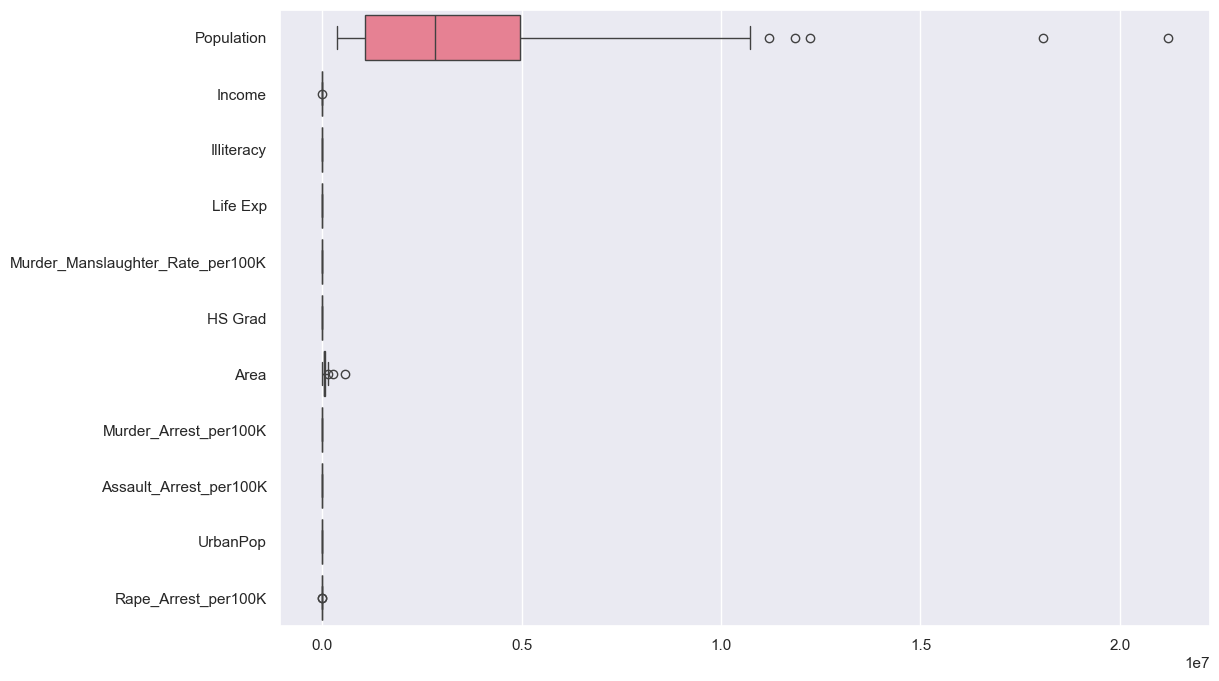

In [15]:
sns.boxplot(us_data_df, orient="h");


### Conduct a pairplot and correlation heatmap between features to identify any potential relationships

From the pairplot below, it seems like that is no clear distinct clusters between any 2 numerical features except for *HS Grad* and *Income* feature pairs which has at least 3 imbalanced clusters via visual inspection and 2 clusters with *HS Grad* and *Life Exp* feature pairs. 

From the correlation heatmap and pairplot, it was noticed that there is strong positive correlation between *murder_manslaughter_rate_per_100k* and *murder_arrest_rate feature* at 0.93, while life expectancy has a moderate negative correlation with both *murder_manslaughter_rate_per_100k* and *murder_arrest_rate* features at -0.78.

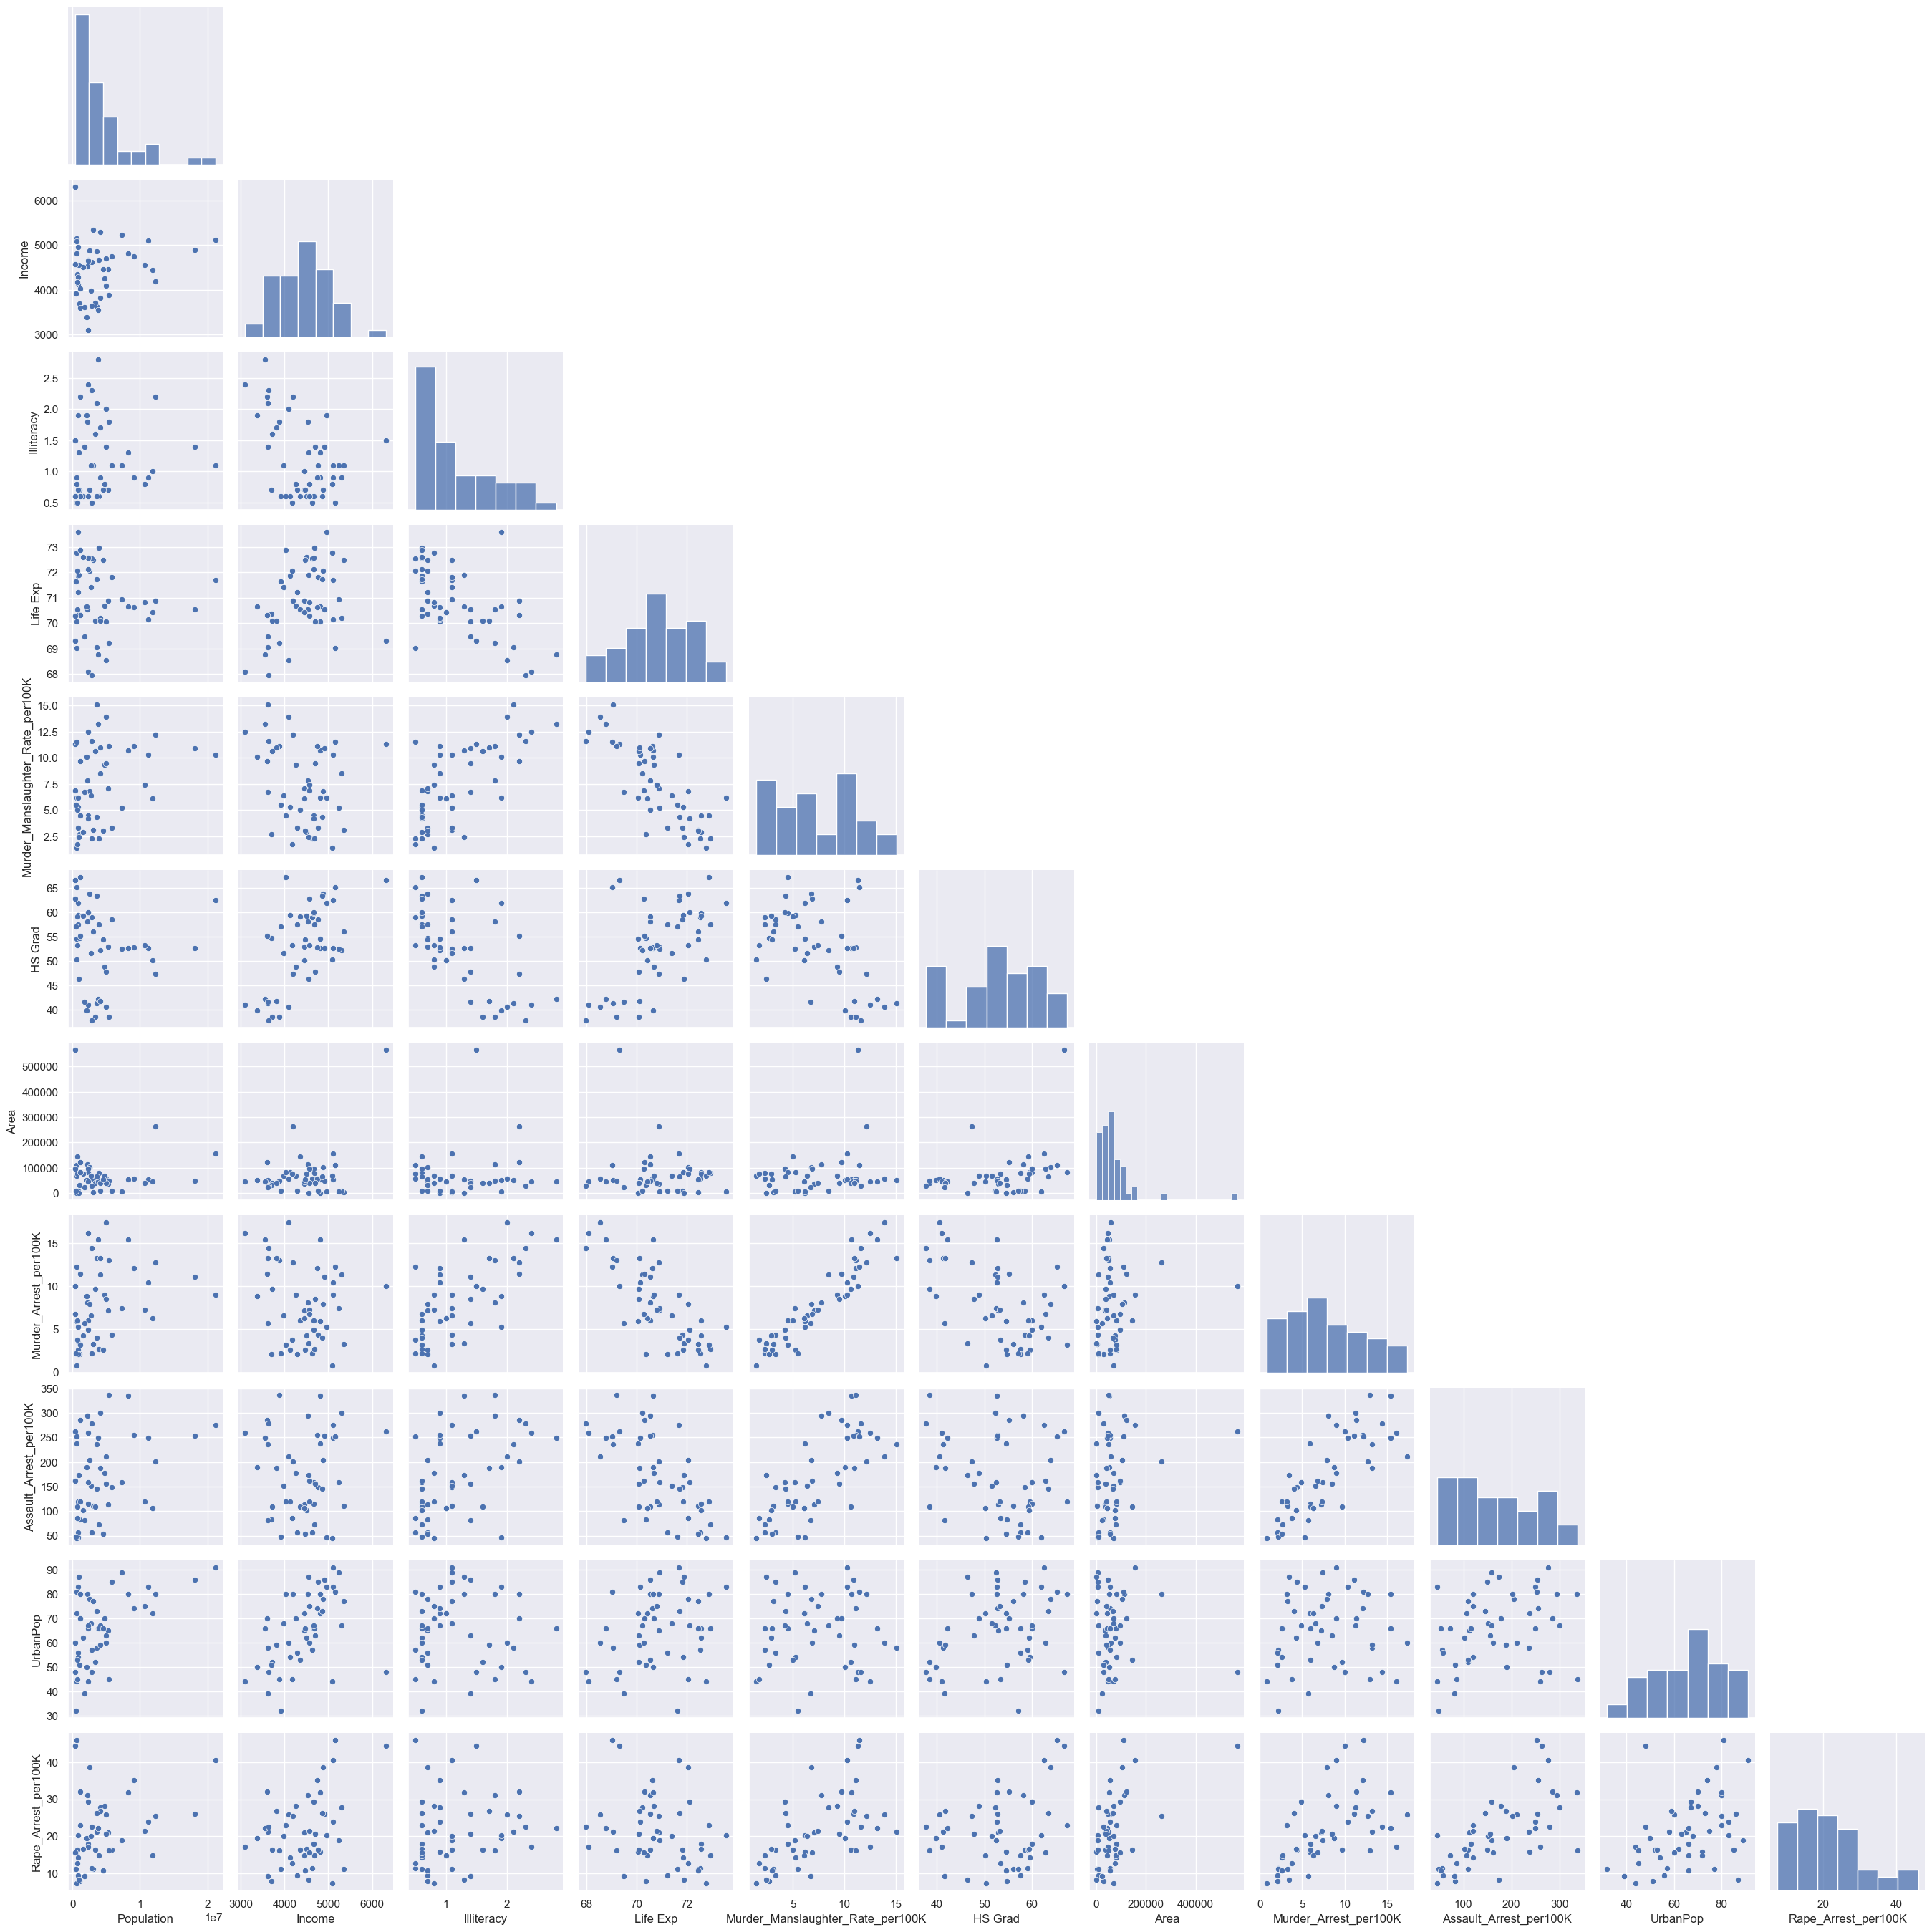

In [16]:
sns.pairplot(us_data_df, corner=True);

C:\Users\quekz\AppData\Local\Temp\ipykernel_24936\505898988.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(us_data_df.corr(), dtype=np.bool))
C:\Users\quekz\AppData\Local\Temp\ipykernel_24936\505898988.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(us_data_df.corr(), dtype=np.bool))
C:\Users\quekz\AppData\Local\Temp\ipykernel_24936\505898988.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a

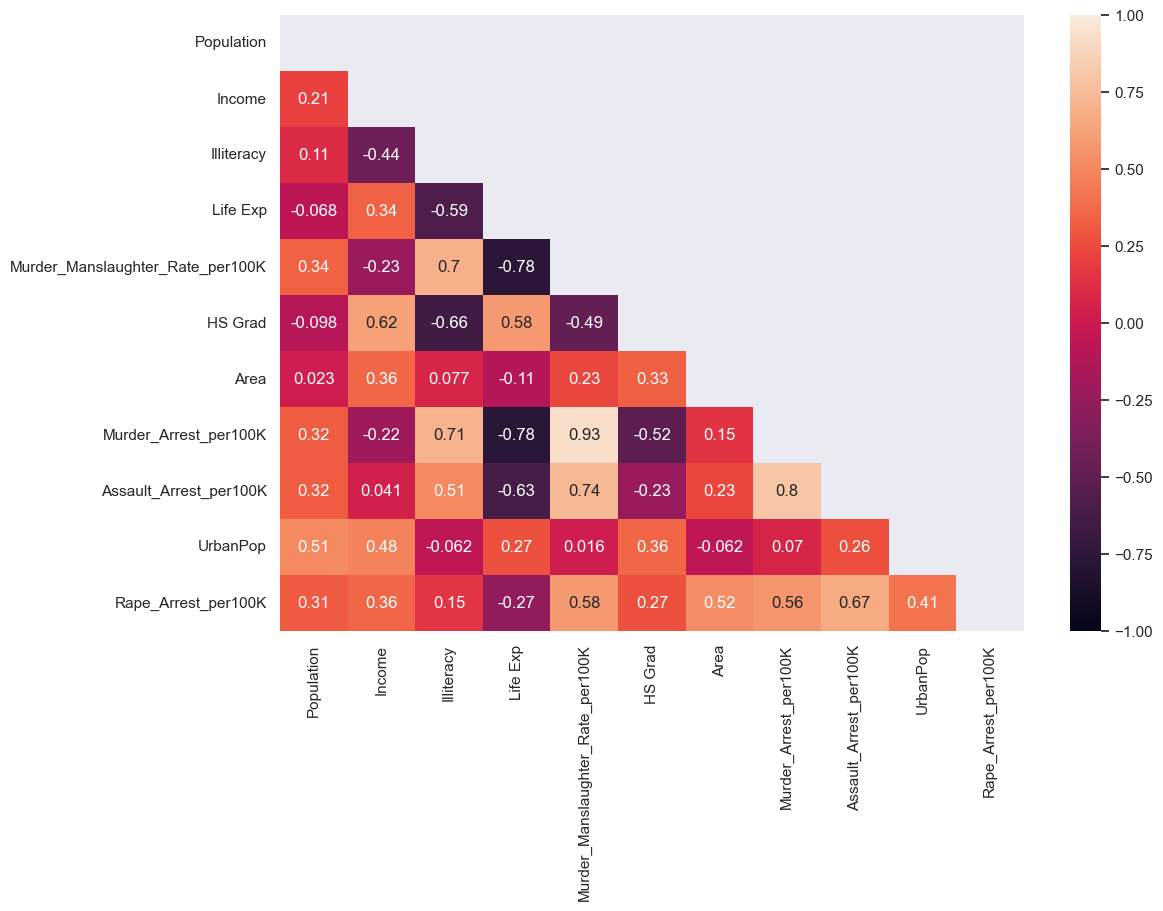

In [17]:
# Heatmap plot
mask = np.triu(np.ones_like(us_data_df.corr(), dtype=np.bool))
sns.heatmap(us_data_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True);

In [18]:
# Convert percentage features to absolute values

percentage_feature_list = ["Illiteracy", "HS Grad", "UrbanPop"]
for col in percentage_feature_list:
    new_col = col+"_abs"
    us_data_df[new_col] = us_data_df[col] * us_data_df["Population"] * 0.01
    us_data_df[new_col] = us_data_df[new_col].astype(int)


# Convert per 100k features to absolute values 
per_100k_feature_list = [col for col in us_data_df.columns if col.endswith("_per100K")]

for col in per_100k_feature_list:
    new_feature = col.replace("_per100K","_abs")
    us_data_df[new_feature] = us_data_df[col] * 10e-6 * us_data_df["Population"]
    us_data_df[new_feature] = us_data_df[new_feature].astype(int)
#us_data_df.drop(columns=per_100k_feature_list, inplace=True)

In [19]:
us_data_df.set_index("State", inplace=True)
us_data_df.columns

Index(['Population', 'Income', 'Illiteracy', 'Life Exp',
       'Murder_Manslaughter_Rate_per100K', 'HS Grad', 'Area', 'Division',
       'Region', 'Murder_Arrest_per100K', 'Assault_Arrest_per100K', 'UrbanPop',
       'Rape_Arrest_per100K', 'Illiteracy_abs', 'HS Grad_abs', 'UrbanPop_abs',
       'Murder_Manslaughter_Rate_abs', 'Murder_Arrest_abs',
       'Assault_Arrest_abs', 'Rape_Arrest_abs'],
      dtype='object')

In [20]:
columns_to_include = [col for col in us_data_df.columns if not col.endswith("_abs")]
arrest_crime_col_list= [col for col in columns_to_include if col.endswith("Arrest_per100K")]
print(arrest_crime_col_list)

# Exclude region or division information 
non_crime_col_list = [col for col in columns_to_include if col!="Division" and col!="Region" and col not in arrest_crime_col_list]
non_crime_col_list

['Murder_Arrest_per100K', 'Assault_Arrest_per100K', 'Rape_Arrest_per100K']


['Population',
 'Income',
 'Illiteracy',
 'Life Exp',
 'Murder_Manslaughter_Rate_per100K',
 'HS Grad',
 'Area',
 'UrbanPop']

In [21]:
# Create 2 subdataframe 
non_crime_us_data_df = us_data_df[non_crime_col_list].copy()
crime_us_data_df = us_data_df[arrest_crime_col_list].copy()

## Identify the type of crime with most arrests

From the boxplot and comparison of arrests ratio below, it suggests that most arrest made involves assault cases as compared to rape and murder cases.

<AxesSubplot:>

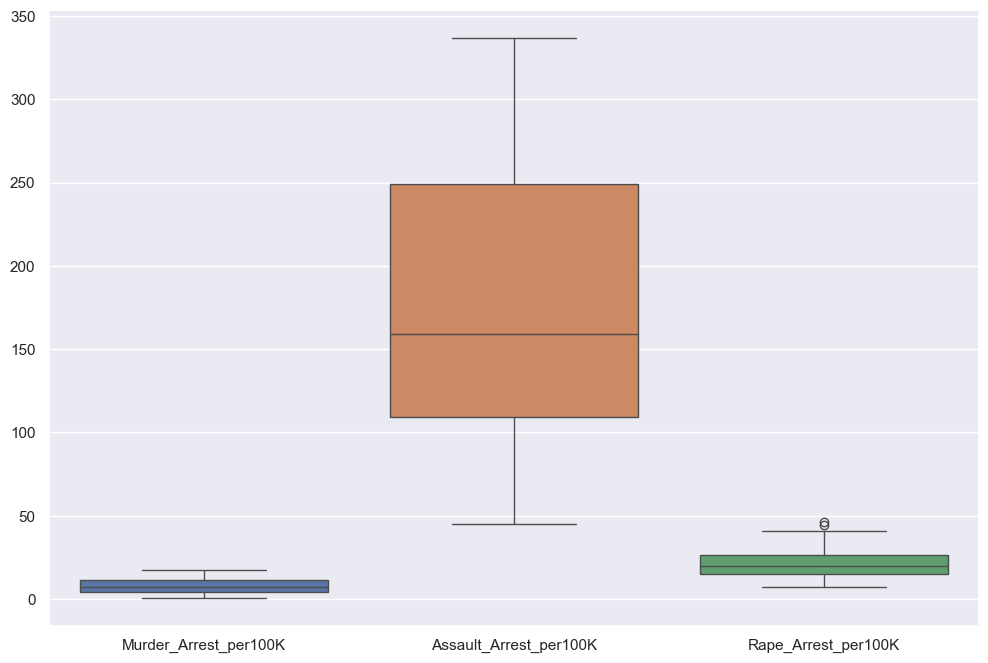

In [22]:
sns.boxplot(data=crime_us_data_df)

In [23]:
# Check if all assault arrest are higher than rape arrest
all(crime_us_data_df["Assault_Arrest_per100K"] > crime_us_data_df["Rape_Arrest_per100K"])

True

## Quick distribution check with normalcy test

Doing a quick distribution check helps us to get a sense on the data distribution. In addition, doing a normalcy test can help us sieve out for non-normally distributed features.

The normalcy test using Shapiro-Wilk Test conducted on the data across states suggest that only the following features
- Assault_Arrest_per100K (Assault Arrest Rate)
- Rape_Arrest_per100K (Rape Arrest Rate)
- Population
- Illiteracy
- Murder_Manslaughter_Rate_per100K (Murder Manslaughter Rate)
- HS Grad
- Area 

do not follow a normal distribution as the null hypothesis of it being normally distributed is rejected at 5% significance test level.

The use of Shapiro-Wilk Test is due to the quote "Although there are various methods for normality testing but for small sample size (n <50), Shapiro–Wilk test should be used as it has more power to detect the nonnormality and this is the most popular and widely used method." from [Descriptive Statistics and Normality Tests for Statistical Data article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/). In our case, 50 data points can be considered almost the same as being small sample size.


A visual inspection on the remaining features based on Kernel Density Estimation plot seems to show that the distribution do not really mirror a typical normal distribution.

p-value for Assault_Arrest_per100K is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.
p-value for Rape_Arrest_per100K is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.


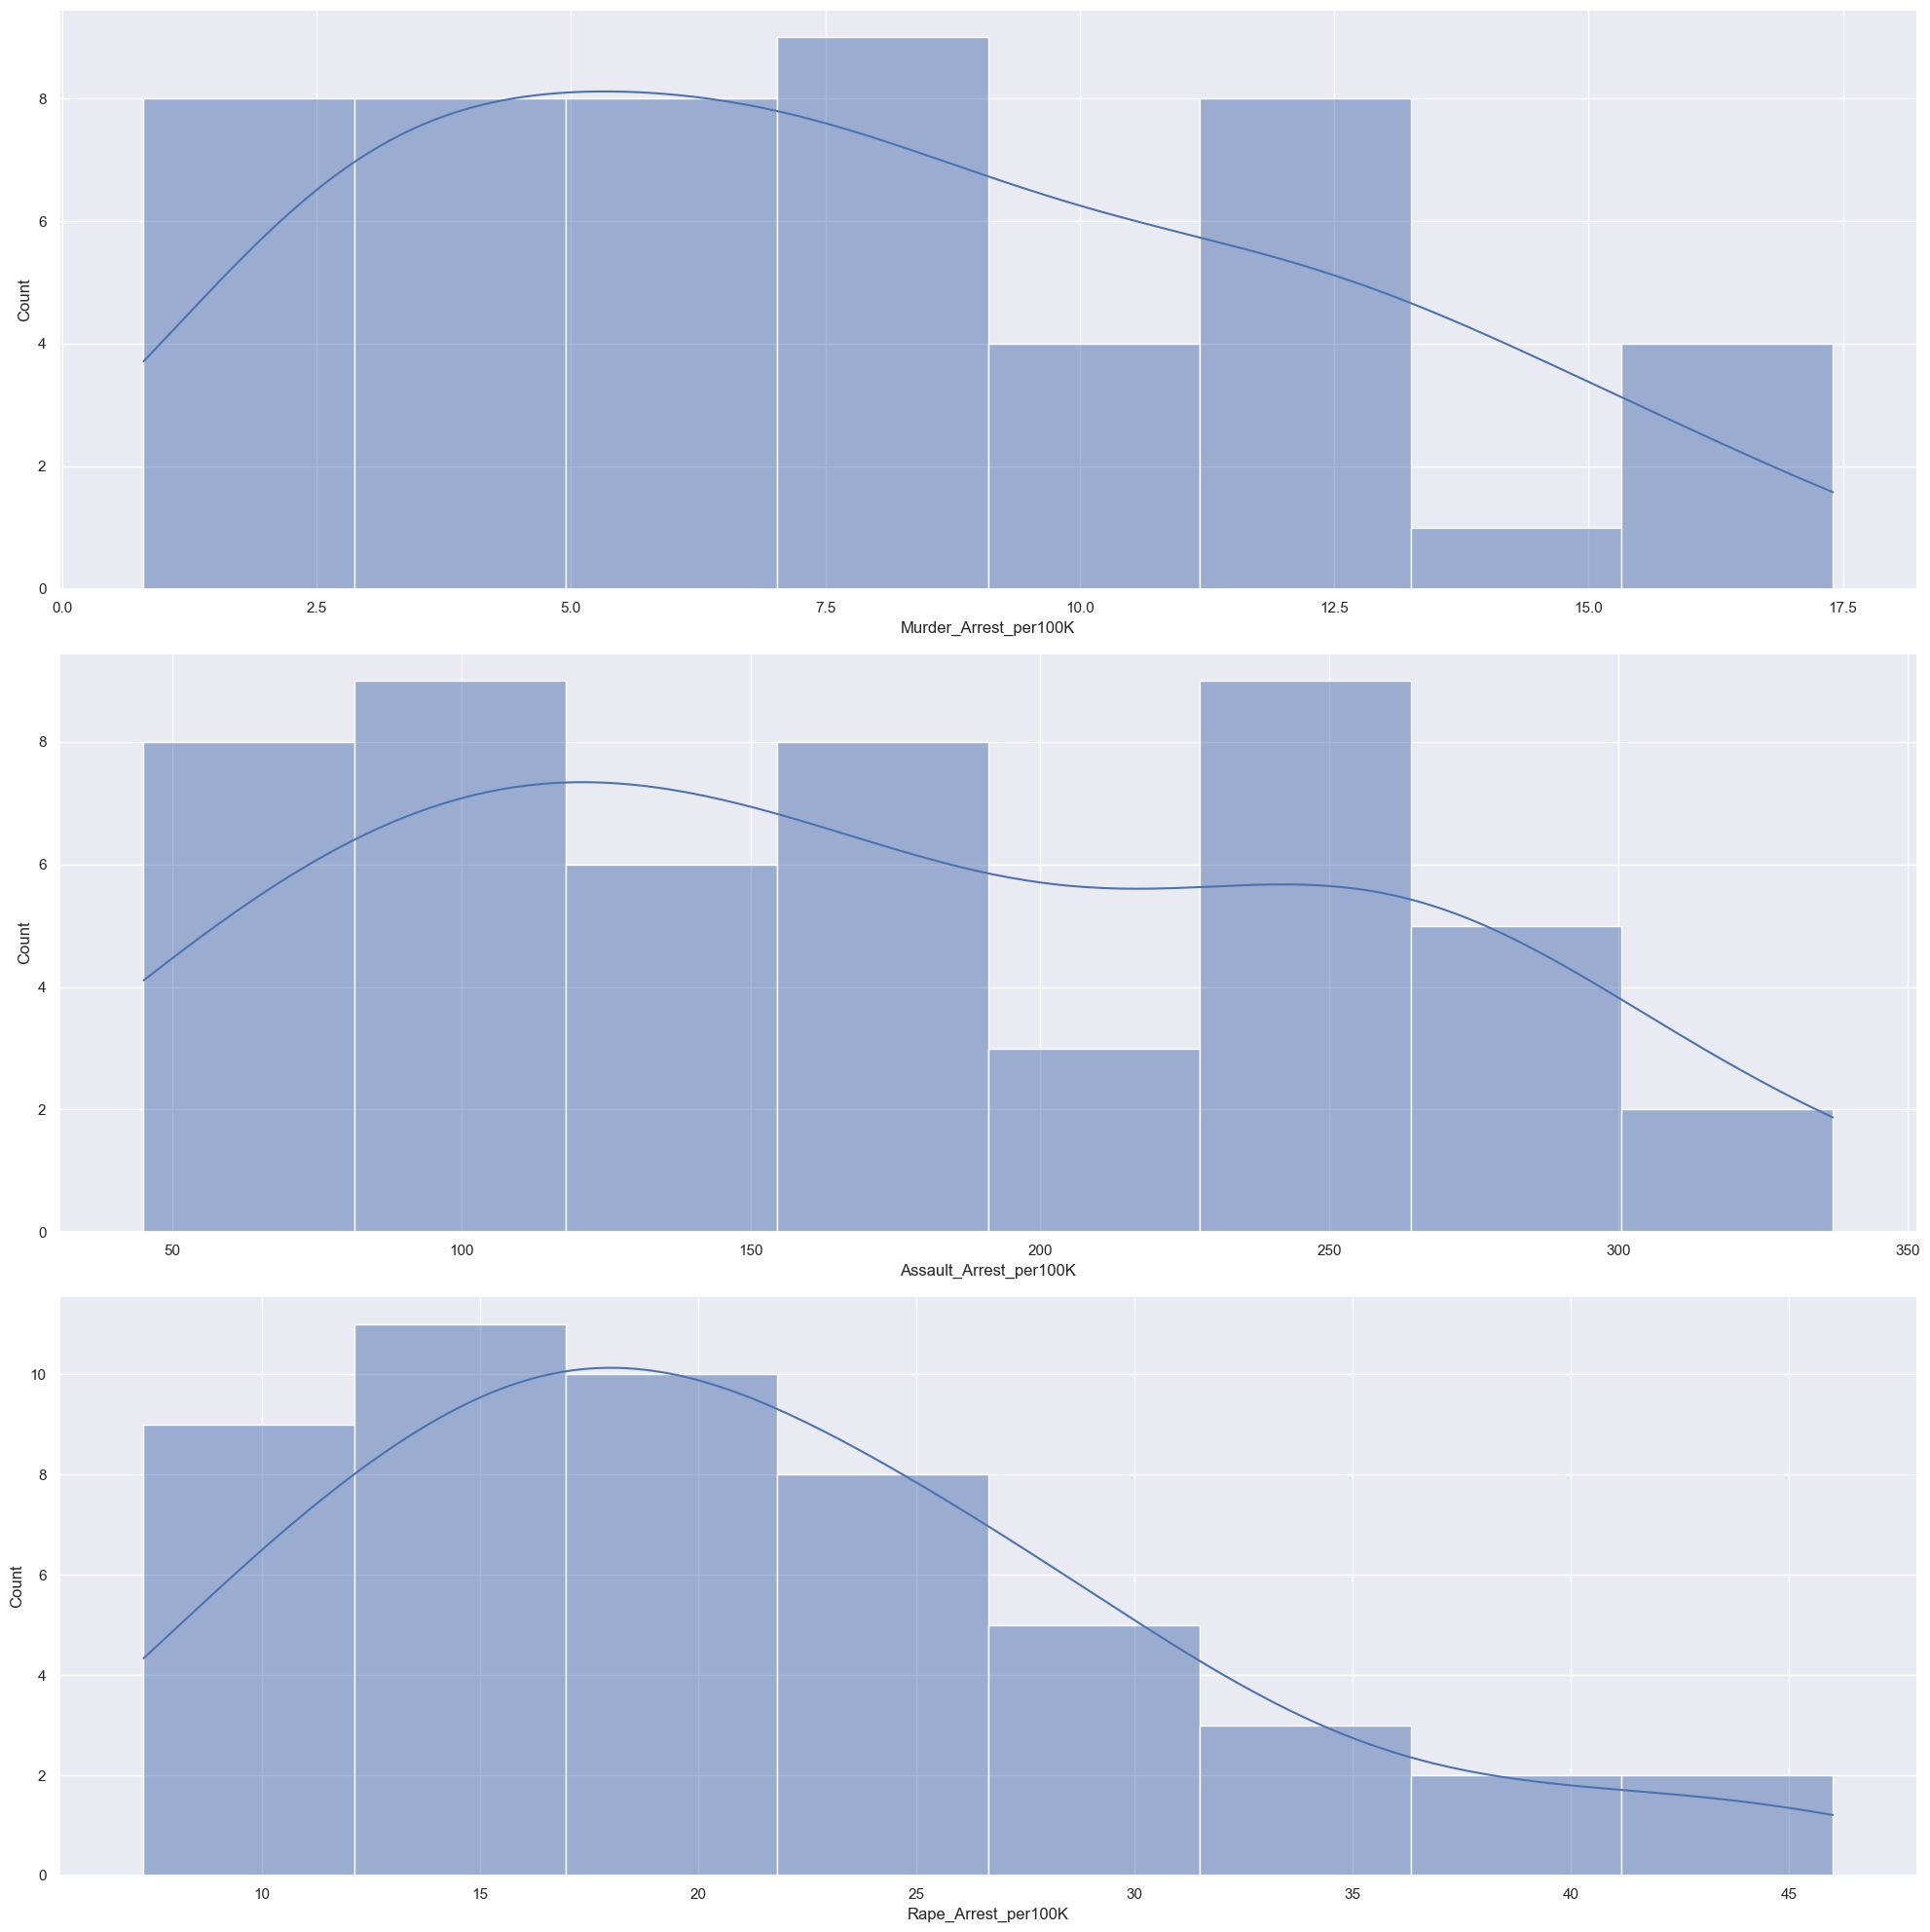

In [24]:
alpha_val = 0.05
fig, ax =plt.subplots(len( arrest_crime_col_list),1, figsize=(20,20))
for index, col in enumerate(arrest_crime_col_list):
    sns.histplot(x=col, data=crime_us_data_df, ax=ax[index], kde=True, bins="sqrt")
    res = stats.shapiro(crime_us_data_df[col].values)
    if res.pvalue < alpha_val:
        print(f"p-value for {col} is < {alpha_val}.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.")

fig.tight_layout()

p-value for Population is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.
p-value for Illiteracy is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.
p-value for Murder_Manslaughter_Rate_per100K is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.
p-value for HS Grad is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.
p-value for Area is < 0.05.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.


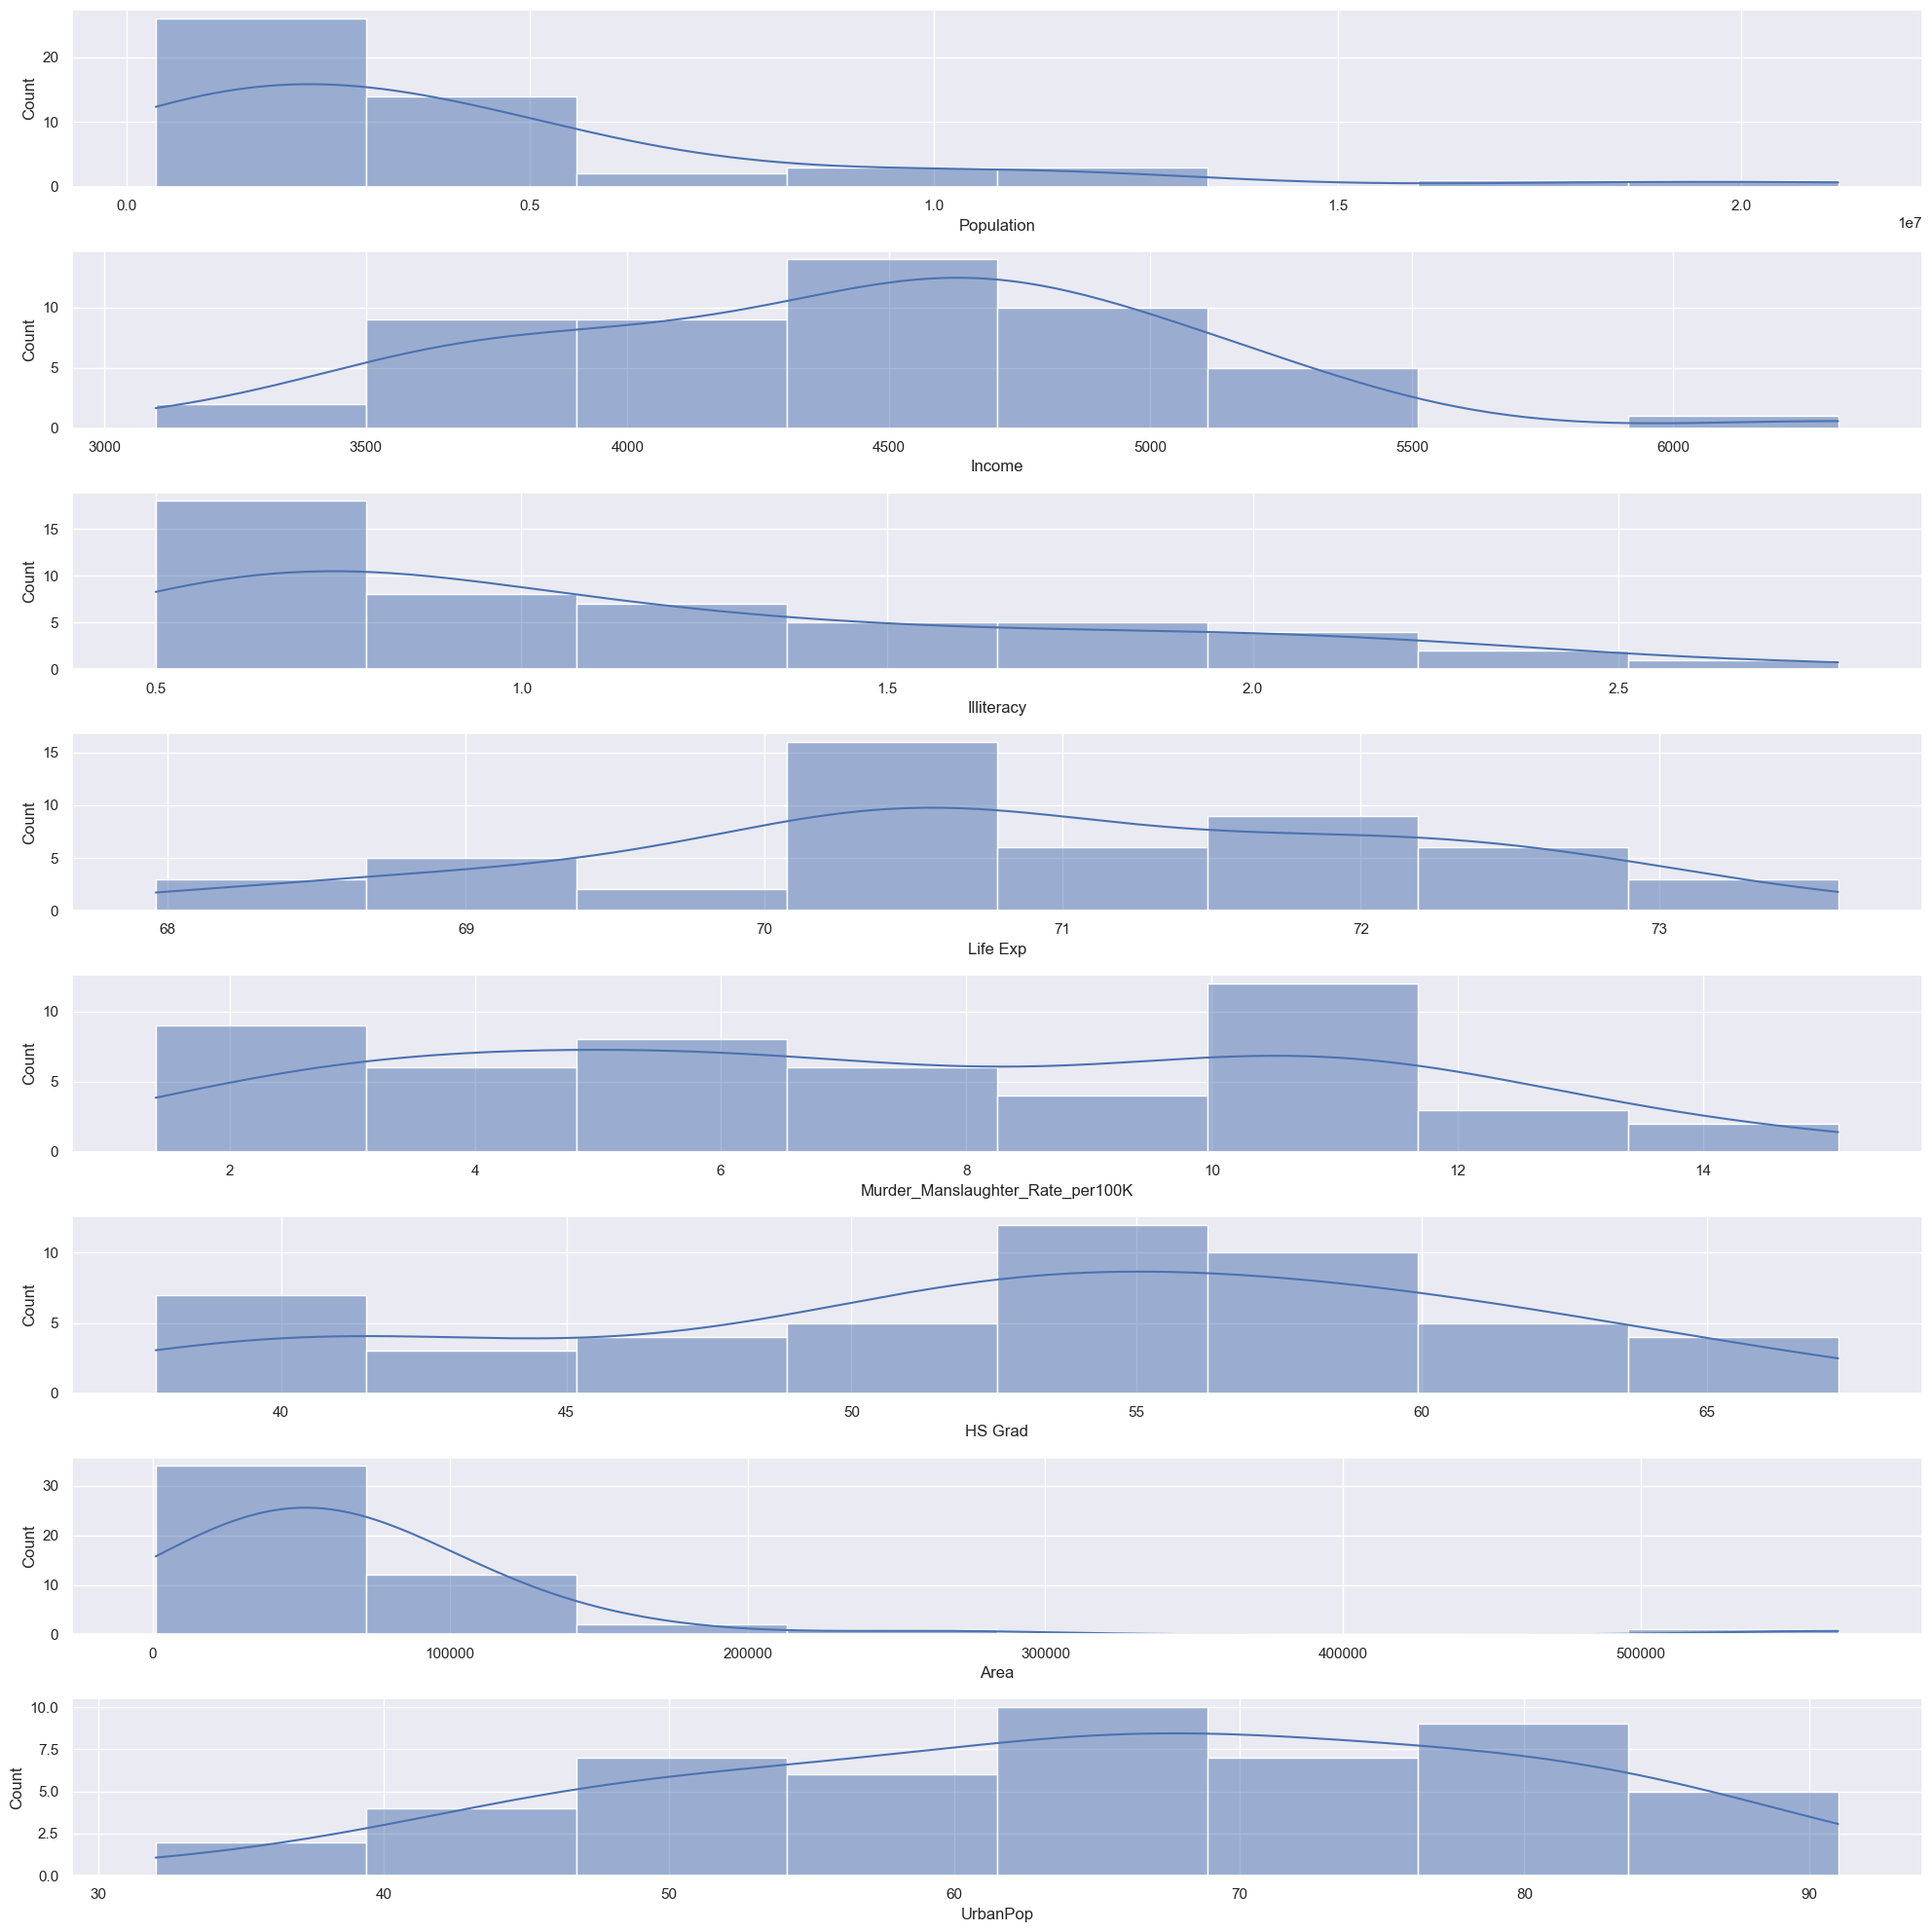

In [25]:
alpha_val = 0.05
fig, ax =plt.subplots(len(non_crime_col_list),1, figsize=(20,20))
for index, col in enumerate(non_crime_col_list):
    sns.histplot(x=col, data=non_crime_us_data_df, ax=ax[index], kde=True, bins="sqrt")
    res = stats.shapiro(non_crime_us_data_df[col].values)
    if res.pvalue < alpha_val:
        print(f"p-value for {col} is < {alpha_val}.The null hypothesis of the values being normal distributed is rejected and thus the feature does not follow a normal distribution.")

fig.tight_layout()

## Question 2.1
Categorise / group the states based on their characteristics.

For this question, given the data revolves around the context of arrests, we try to cluster various states using the 3 different arrest rates for crimes with other features using suitable algorithm, instead of just purely geographic regions. This also takes into consideration that different states have different laws, and grouping by region or location for arrest case would not be relevant.


In this case, clustering would be done via agglomerative clustering as it is quick and easy to implement. The optimal cluster is decided through interpeting dendrograms that is applied on the dataset where 'ward' method is used for minimizing the total within-cluster variance when pairing clusters for merging.

We can plot a scatter plot for the various arrest rates for murder, rape and assault

Scatterplot for Murder Arrest Rate against state population

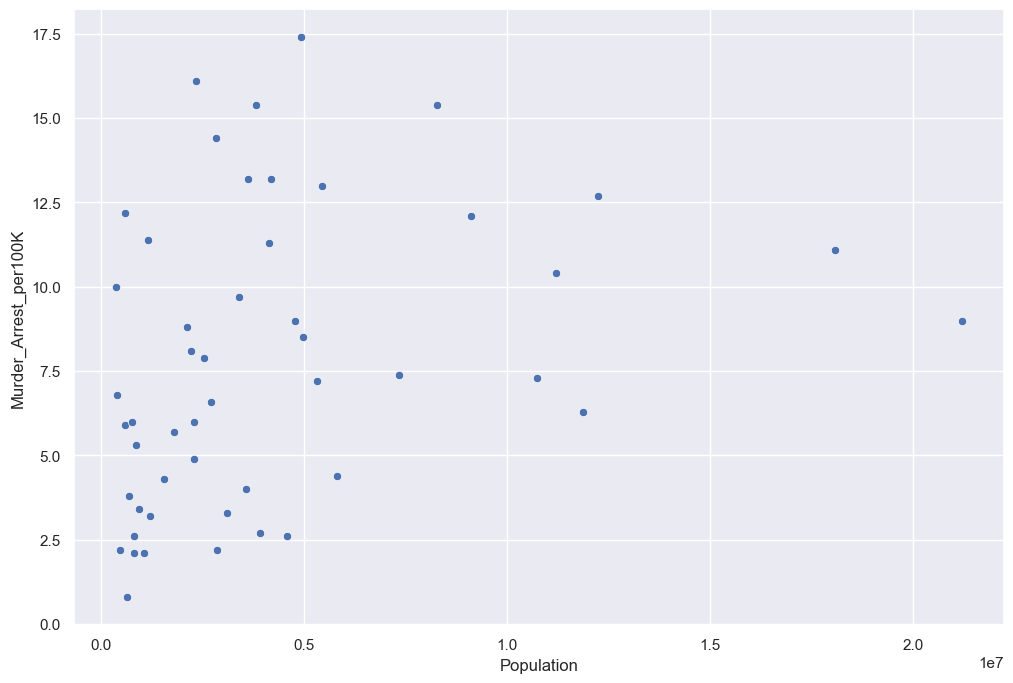

In [26]:
sns.scatterplot(x="Population", y="Murder_Arrest_per100K" , data=us_data_df);

Scatterplot for Rape Arrest Rate against state population

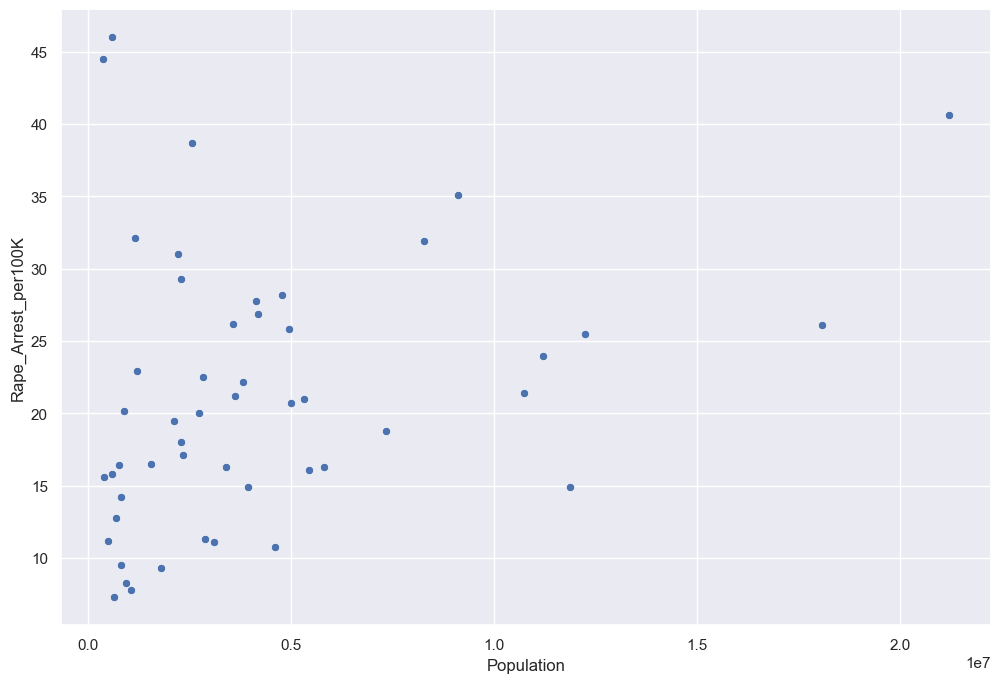

In [27]:
sns.scatterplot(x="Population", y="Rape_Arrest_per100K" ,data=us_data_df);

Scatterplot for Assault Arrest Rate against state population

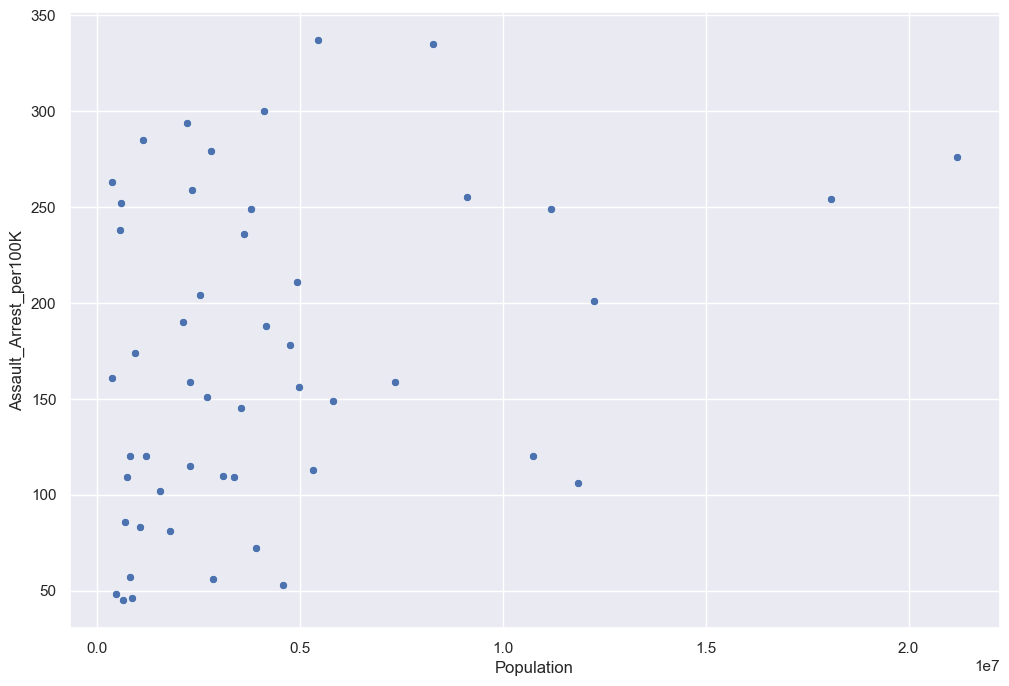

In [28]:
sns.scatterplot(x="Population", y="Assault_Arrest_per100K" ,data=us_data_df);

We need to scale the data to common scale for clustering purposes so that there is no scale disadvantage amongst feature. Furthermore, only numerical features can be used and we will use the original data features for clustering purposes.

In [29]:
us_data_df.drop(columns=["Division", "Region"], inplace=True)

# Exclude created features with _abs suffix for this clustering process to find categories since they are additional information to its non absoulte counterparts

no_abs_col_list = [col for col in us_data_df.columns if not col.endswith("_abs")]

default_us_data_df = us_data_df[no_abs_col_list].copy()

std_scaler = StandardScaler()
default_us_data_df_scaled = std_scaler.fit_transform(default_us_data_df)
default_us_data_df_scaled = pd.DataFrame(default_us_data_df_scaled, columns = default_us_data_df.columns, index= default_us_data_df.index)
default_us_data_df_scaled.head()

,Population,Income,Illiteracy,Life Exp,Murder_Manslaughter_Rate_per100K,HS Grad,Area,Murder_Arrest_per100K,Assault_Arrest_per100K,UrbanPop,Rape_Arrest_per100K
State,,,,,,,,,,,
Alabama,-0.142867,-1.334552,1.541248,-1.376023,2.113047,-1.476772,-0.237101,1.255179,0.790787,-0.526195,-0.003451
Alaska,-0.878225,3.089295,0.546895,-1.180373,1.073216,1.699888,5.868329,0.513019,1.118060,-1.224067,2.509424
Arizona,-0.460315,0.154859,1.044071,-0.247272,0.115476,0.624326,0.505283,0.072361,1.493817,1.009122,1.053466
Arkansas,-0.483394,-1.738961,1.209797,-0.164497,0.744848,-1.651863,-0.222457,0.234708,0.233212,-1.084492,-0.186794
California,3.835528,1.114921,-0.116008,0.625629,0.799576,1.187120,1.013678,0.281093,1.275635,1.776781,2.088814


Create a dendrogram using ward method which analyses the variance of clusters. It is also said to be the most suitable method for quantitative variables. Measuring the vertical distances and taking the max (identified with Id 1), and looking at the colors of the clusters, it indicates that 3 is the optimal clusters.

Text(0, 0.5, 'Euclidean distances')

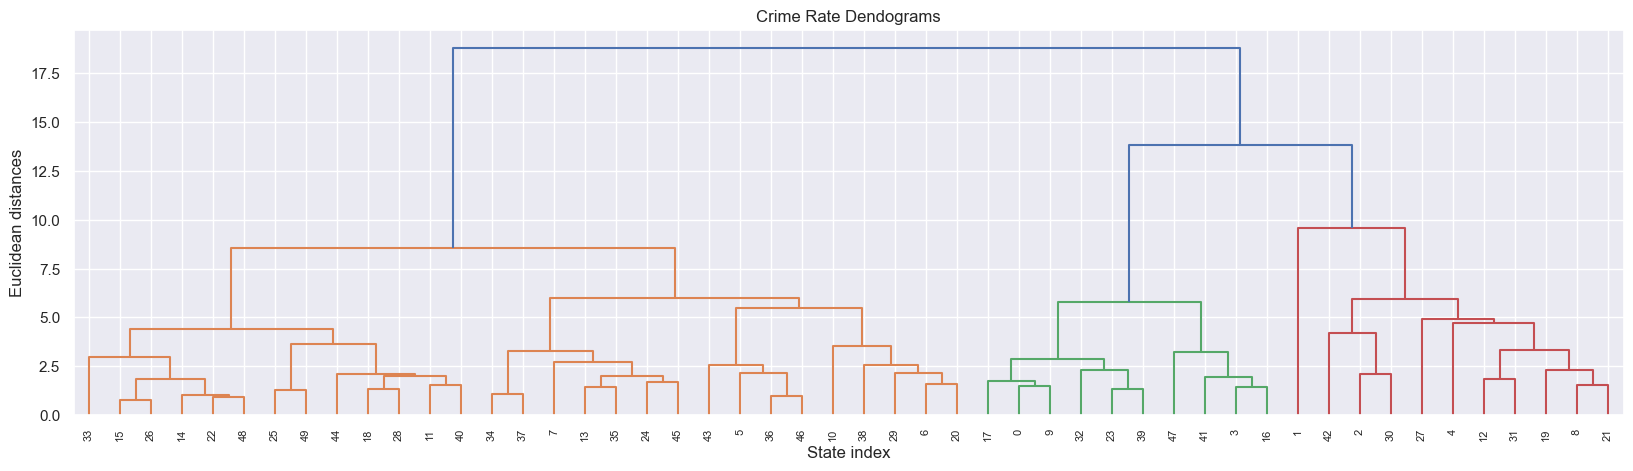

In [35]:
plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendograms")
dend = sch.dendrogram(sch.linkage(default_us_data_df_scaled, method='ward'))
plt.xlabel('State index')
plt.ylabel('Euclidean distances')

Fit the Agglomerative Clustering and do a prediction to get cluster labels. We can use the labels for clustering the states.

In [39]:
# Fit the Agglomerative Clustering and do a fit and prediction to get cluster labels
 
ac_clustering = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage ='ward')
default_us_data_df["Cluster_labels"] = ac_clustering.fit_predict(default_us_data_df)


In [41]:
default_us_data_df.columns

Index(['Population', 'Income', 'Illiteracy', 'Life Exp',
       'Murder_Manslaughter_Rate_per100K', 'HS Grad', 'Area',
       'Murder_Arrest_per100K', 'Assault_Arrest_per100K', 'UrbanPop',
       'Rape_Arrest_per100K', 'Cluster_labels'],
      dtype='object')

## Question 2.2
What factors are statistically significant in predicting Assault rates?

Dataset: USArrest.csv (main). You may wish to use the other datasets to enhance your study.

Illiteracy and Income are the 2 key statistically significant factors at 5% significance level.


### How is it derived:


In view of predicting Assault rates, we can use ordinary least square regression with 4 identified features and predict assault arrest (as a proxy feature) to actual assault rate.

We can use a regression model assault rates (dependent factor) as a function of other features (predictor factors) based on the following:
- Illiteracy rate (Illteracy)
- Income
- UrbanPop (Urban population)

where we need to have a standardised regression coefficient for fair comparison due to the use of common scale. Other arrest related features would not be included as the high correlation may be due to confounding effects (recalcitrant culprit) maybe involved in both assault/rape/murder crimes during same period. Non-arrest related features with moderate/strong correlation (more than 0.5 in absolute correlations) are excluded from regression modelling to avoid complexities in the algorithm and increasing risks of error and for simpicity purposes.

Assumptions: We assume that any arrest can only be categorised into either arrest cases of Murder, Assault or Rape since they are crimes of different severity. Based on the high positive correlation between murder arrest and murder/manslaughter rate features, I suppose similar correlation would apply for assault case if assault rate information is known, and that all crimes are treated equally by authorities. It would be illogical to include life expectancy as predictor feature to assault rates and does not indicate some form of vulnerability for crimes to occur.



### Create Predictor and predicted features for regression purposes.

There is no need to do a typical machine learning split since we are not doing any model evaluation purpose. Instead, we are just trying to model using the entire data to sieve out features of higher significance.

In [45]:
predictors_col_list = [
    'Population',
    'Illiteracy', 
    'Income']

# State level data
X_df, y_df = default_us_data_df[predictors_col_list], default_us_data_df[["Assault_Arrest_per100K"]]

In [46]:
# State
std_scaler = StandardScaler()
X_df_scaled = std_scaler.fit_transform(X_df)
X_df_scaled = pd.DataFrame(X_df_scaled, columns = X_df.columns, index= X_df.index)
X_df_scaled.head()

,Population,Illiteracy,Income
State,,,
Alabama,-0.142867,1.541248,-1.334552
Alaska,-0.878225,0.546895,3.089295
Arizona,-0.460315,1.044071,0.154859
Arkansas,-0.483394,1.209797,-1.738961
California,3.835528,-0.116008,1.114921


### Generate statistical summary for statistical significance while using least square model (regression) to fit the data

In [47]:
# State
X_df_scaled = sm.add_constant(X_df_scaled)
reg_estimator = sm.OLS(y_df, X_df_scaled)
reg_estimator_fitted = reg_estimator.fit()
print(reg_estimator_fitted.summary())

                              OLS Regression Results                              
Dep. Variable:     Assault_Arrest_per100K   R-squared:                       0.383
Model:                                OLS   Adj. R-squared:                  0.342
Method:                     Least Squares   F-statistic:                     9.503
Date:                    Sun, 03 Dec 2023   Prob (F-statistic):           5.35e-05
Time:                            19:49:28   Log-Likelihood:                -279.53
No. Observations:                      50   AIC:                             567.1
Df Residuals:                          46   BIC:                             574.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       